# Bite Size Bayes

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

[In the previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/05_test.ipynb) ...

So far just Bayes's Theorem, now on to Bayesian statistics

and here's the function we defined

## Probability Mass Functions

When we do more than one update, we don't always want to keep the whole Bayes table.  In this section we'll replace the Bayes table with a more compact representation, using a Pandas Series.

Here's a function that takes a sequence of values, `xs`, and their corresponding probabilities, `ps`, and returns a Pandas Series:

In [2]:
def make_pmf(xs, ps, **options):
    """Make a Series that represents a PMF.
    
    xs: sequence of values
    ps: sequence of probabilities
    options: keyword arguments passed to Series constructor
    
    returns: Pandas Series
    """
    pmf = pd.Series(ps, index=xs, **options)
    return pmf

In [3]:
def bayes_update(pmf, likelihood):
    """Do a Bayesian update.
    
    pmf: Series that represents the prior
    likelihood: sequence of likelihoods
    
    returns: float probability of the data
    """
    pmf *= likelihood
    prob_data = pmf.sum()
    pmf /= prob_data
    return prob_data

In [4]:
xs = np.arange(101)
prior = 1/101

pmf = make_pmf(xs, prior)

In [5]:
likelihood_vanilla = xs / 100
likelihood_chocolate = 1 - likelihood_vanilla

In [6]:
data = 'VVC'

for cookie in data:
    if cookie == 'V':
        bayes_update(pmf, likelihood_vanilla)
    else:
        bayes_update(pmf, likelihood_chocolate)

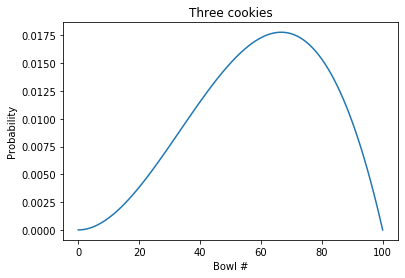

In [7]:
pmf.plot()

plt.xlabel('Bowl #')
plt.ylabel('Probability')
plt.title('Three cookies');

## The Euro problem

In this notebook we'll work on a problem from David MacKay's book, [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/p0.html), which is the book where I first learned about Bayesian statistics.  MacKay writes:

> A statistical statement appeared in The Guardian on
Friday January 4, 2002:
>
> >"When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’."
>
> But [asks MacKay] do these data give evidence that the coin is biased rather than fair?

To answer this question, we have to make some modeling decisions.

First, let's assume that if you spin a coin on edge, there is some probability that it will land heads up.  I'll call that probability $x$.

Second, let's assume that $x$ varies from one coin to the next, depending on how the coin is balanced and maybe other factors.

With these assumptions we can formulate MacKay's question as an inference problem: given the data, 140 heads and 110 tails, what do we think $x$ is for this coin.

This formulation is similar to the 101 Bowls problem we saw in the previous notebook; in fact, we will use the same likelihoods.

But in the 101 Bowls problem, we are told that we choose a bowl at random, which implies that all bowls have the same prior probability.

For the Euro problem, we have to think harder.  What values of $x$ do you think are reasonable?

I seems likely that many coins are "fair", meaning that the probability of heads is close to 50%.  Do you think there are coins where $x$ is 75%?  How about 90%?

To be honest, I don't really know.  To get started, I will assume that all values of $x$, from 0% to 100%, are equally likely.  So that's the same prior we used for the 101 Bowls.

So here's the prior:

In [8]:
xs = np.arange(101)
prior = 1/101
pmf = make_pmf(xs, prior)

Here are the likelihoods for heads and tails:

In [9]:
likelihood_heads = xs / 100
likelihood_tails = 1 - likelihood_heads

And here are the updates for 140 heads and 110 tails.

In [10]:
for i in range(140):
    bayes_update(pmf, likelihood_heads)

for i in range(110):
    bayes_update(pmf, likelihood_tails)

Here's what the results look like:

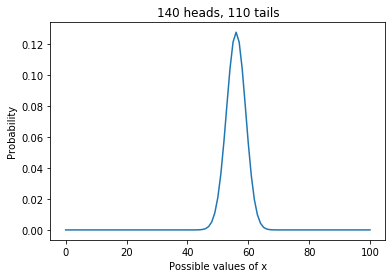

In [11]:
pmf.plot()

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('140 heads, 110 tails');

This curve shows the "posterior distribution" of $x$; a "distribution" is a set of possible values and their probabilities.

## Put a function on it

Before we go on, let's put that update in a function, because we are going to need it again.

In [12]:
def bayes_update_euro(pmf, data):
    """Do a Bayesian update.
    
    pmf: Series that represents a prior PMF
    data: tuple of number of heads, tails
    """
    heads, tails = data
    xs = pmf.index
    
    likelihood_heads = xs / 100
    likelihood_tails = 1 - likelihood_heads

    for i in range(heads):
        bayes_update(pmf, likelihood_heads)

    for i in range(tails):
        bayes_update(pmf, likelihood_tails)

This function takes a PMF that represents the prior, and a tuple that contains the number of heads and tails.

Here's the uniform prior again.

In [13]:
xs = np.arange(101)
prior = 1/101
uniform = make_pmf(xs, prior)

Here's the update.

In [14]:
data = 140, 110
bayes_update_euro(uniform, data)

And here are the results again.

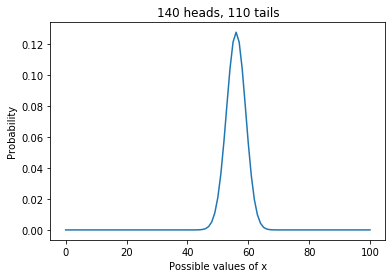

In [15]:
uniform.plot()

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('140 heads, 110 tails');

## A better prior

But remember that this result is based on a uniform prior, which assumes that any value of $x$ from 0 to 100 is equally likely.

Given what we know about coins, that's probabily not true.  I can believe that if you spin a lop-sided coin on edge, it might be somewhat more likely to land on heads or tails.  

But unless the coin is heavily weighted on one side, I would be surprised if $x$ were greater than 60% or less than 40%.

Of course, I could be wrong, but in general I would expect to find $x$ closer to 50%, and I would be surprised to find it near 0% or 100%.

I can represent that prior believe with a triangle-shaped prior.

First I'll make an array that ramps up from 0 to 100 an array that ramps down from 100 to 0.

In [16]:
ramp_up = xs
ramp_down = 100 - ramp_up

To construct a triangle prior I'll start with a copy of `ramp_up` and replace the second half with `ramp_down`.

In [17]:
prior = ramp_up.copy()

high = (xs > 50)
prior[high] = ramp_down[high]

Then I'll put the results into a PMF and normalize it so it adds up to 1.

In [18]:
triangle = make_pmf(xs, prior)
triangle /= triangle.sum()

Here's what the triangle prior looks like.

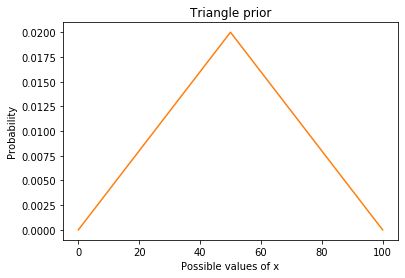

In [19]:
triangle.plot(color='C1')

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('Triangle prior');

Now let's update it with the data.

In [20]:
data = 140, 110
bayes_update_euro(triangle, data)

And plot the results, along with the posterior based on a uniform prior.

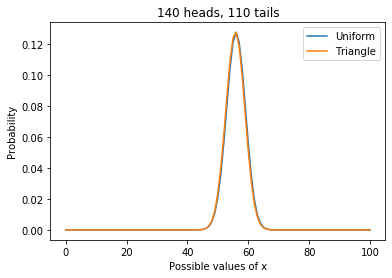

In [21]:
uniform.plot(label='Uniform')
triangle.plot(label='Triangle')

plt.xlabel('Possible values of x')
plt.ylabel('Probability')
plt.title('140 heads, 110 tails')
plt.legend();

The posterior distributions are almost identical because, in this case, we have enough data to "swamp the prior"; that is, the posteriors depend strongly on the data and only weakly on the priors.

This is good news, because it suggests that we can use data to resolve arguments.  Suppose two people disagree about the correct prior.  If neither can persuade the other, they might have to agree to disagree.

But if they get new data, and each of them does a Bayesian update, they will usually find their beliefs converging.

And with enough data, the remaining difference can be so small that it makes no difference in practice.

## Summarizing the posterior distribution

The posterior distribution contains all of the information we have about the value of $x$.  But sometimes we want to summarize this information.

We have already seen one way to summarize a posterior distribution, the Maximum Aposteori Probability, or MAP:

In [22]:
uniform.idxmax()

56

`idxmax` returns the value of $x$ with the highest probability.

In this example, we get the same MAP with the triangle prior:

In [23]:
triangle.idxmax()

56

Another way to summarize the posterior distribution is the posterior mean.

Given a set of values, $x_i$, and the corresponding probabilities, $p_i$, the mean of the distribution is:

$\sum_i x_i p_i$

Using the posterior PMF, we can compute it like this:

While we're at it, I'll make a function to compute the posterior mean, too:

In [24]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

Here's the posterior mean based on the uniform prior:

In [25]:
pmf_mean(uniform)

55.95238095238095

And here's the posterior mean with the triangle prior:

In [26]:
pmf_mean(triangle)

55.74349943859505

The posterior means are not identical, but they are close enough that the difference probably doesn't matter.

In this example, the posterior mean is very close to the MAP.  That's true when the posterior distribution is symmetric, but it is not always true.

If someone asks what we think $x$ is, the MAP or the posterior mean might be a good answer.

But MacKay asked a different question: do these data give evidence that the coin is biased rather than fair?

We have more work to do before we can really answer this question.  But first, I want to rule out an approach that is tempting, but incorrect.

## Posterior probability

If the coin is "fair", that means that $x$ is 50%.  So it might be tempting to use the posterior PMF to compute the probability that $x$ is 50%:

In [27]:
uniform[50]

0.020976526129544655

The result is the posterior probability that $x$ is 50%, but it is not the probability that the coin is fair.

The problem is that $x$ is really a continuous quantity, which means it could have any value between 0 and 1.  

For purposes of computation, I broke this interval into 101 discrete values, but that was an arbitrary choice.  I could have done the computation with 201 hypotheses, like this:

In [28]:
xs2 = np.linspace(0, 100, 201)
prior2 = 1/201

uniform2 = make_pmf(xs2, prior2)
len(uniform2)

201

Here's the update.

In [29]:
bayes_update_euro(uniform2, data)

And here's what the results look like.

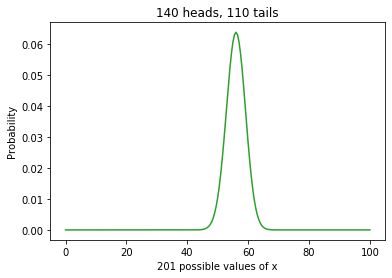

In [30]:
uniform2.plot(color='C2')

plt.xlabel('201 possible values of x')
plt.ylabel('Probability')
plt.title('140 heads, 110 tails');

The results are visually similar, but you might notice that the curve is a little smoother at the peak.

The MAPs are the same and the posterior means are almost the same:

In [31]:
uniform.idxmax(), uniform2.idxmax()

(56, 56.0)

In [32]:
pmf_mean(uniform), pmf_mean(uniform2)

(55.95238095238095, 55.95238095238094)

But the total probability is spread out over twice as many hypotheses, so the proability of any single hypothesis is smaller.

If use both posteriors to compute the probability that $x$ is 50%, we get very different results.

In [33]:
uniform[50], uniform2[50]

(0.020976526129544655, 0.01048826306477235)

Because $x$ is continuous, we divided the interval into discrete values.  But the number of values was an arbitrary choice, so the probability of any single value is not meaningful. 

However, we can meaningfully compute the probability that $x$ falls in an interval.

## Credible intervals

We can use a Booleans series to select values from the posterior distribution and add up their probabilities.

Here's a function that computes the total probability of all values less than or equal to a given value of $x$.

In [34]:
def prob_le(pmf, threshold):
    le = (pmf.index <= threshold)
    total = pmf[le].sum()
    return total

For example, here's the probability that $x$ is less than or equal to 60%, based on the uniform prior with 101 values.

In [35]:
prob_le(uniform, 60)

0.928955163489148

Here's what we get with 201 values.

In [36]:
prob_le(uniform2, 60)

0.9164519507463521

And with the triangle prior

In [37]:
prob_le(triangle, 60)

0.9384439012832195

The results are not identical, but they are close enough that the differences might not matter.

So let's say that the probability is 92% that $x$ is less than or equal to 61.

I'll also compute the probability that $x$ is less than or equal to 51:

In [38]:
prob_le(uniform, 50), prob_le(uniform2, 50), prob_le(triangle, 50)

(0.04056797774604359, 0.034538255921946155, 0.04535722804399313)

It looks like the probability is about 4% that $x$ is less than 50.

Putting these results together, we can estimate the probability that $x$ is between 50 and 60; it's about 92% - 4% = 88%.

And interval like this is called a "credible interval" because it tells us how credible it is that $x$ falls in the interval.

In this case the interval from 50 to 60 is an 88% credible interval.

## Summary

In this notebook, we used data from a coin-spinning experiment to estimate the probability that a given coin lands on heads.

We tried three different priors: uniform distributions with 101 and 201 values, and a triangle distribution.  The results are similar, which indicates that we have enough data to "swamp the priors".

And we summarized the posterior distributions three ways, computing the value with Maximum Aposteori Probability (MAP), the posterior mean, and a credible interval.

Although we have made progress, we have not yet answered the question I started with, "Do these data give evidence that the coin is biased rather than fair?"

We'll come back to this in a future notebook, but [in the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/08_soccer.ipynb), we'll take on a different question, which I call the World Cup problem.